#### **Q5.** Using one-vs-all classifier to do multi-class classification

Another way to perform multi-class classification is by using the one-vs-all method. Given a training set with labels, we know the number of possible classes. Suppose there are `n` classes, thus for each class we have to modify the labels such that it only differentiates samples *from a particular class* or *not from the particular class*. Thus if there are `n` classes, we need to generate `n` new binary labels from the initial multi-class label.

With the new binary labels that is used to train the binary classification of a class from the other classes, we can learn the parameters for such binary classification. In my experiments here, the logistic loss was used to do the training of the `4` binary classification models. Thus we will obtain a total of `n` models. With the `n` learnt models we can then evaluate the probability by using the sigmiod function. The class of the binary classifier with the highest probability will then the predicted class.

In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import *

In [2]:
folders = ['bird', 'cat','airplane','automobile']
train_path_list = []
test_path_list = []
train_dir = 'C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/train/'
test_dir = 'C:/Users/zlai/Documents/repo/HomeworkTex/ML/hw/homework 1/data/test/'
for folder in folders:
    l_train = train_dir + folder 
    l_test = test_dir + folder
    train_path_list.append(l_train)
    test_path_list.append(l_test)

In [3]:
# loading raw pixel features
x1_train, y1_train = load_data(train_path_list, feature='raw')
x1_test, y1_test = load_data(test_path_list, feature='raw')

# loading histogram features
x2_train, y2_train = load_data(train_path_list, feature = None)
x2_test, y2_test = load_data(test_path_list, feature = None)

In [4]:
# normalise the raw pixel features, we do not normalize the histogram 
# features as from Q2,3 normalization gives lower accuracy
x1_train = x1_train/255
x1_test = x1_test/255

In [5]:
# adding of biases
x1_train = add_bias(x1_train)
x1_test = add_bias(x1_test)
x2_train = add_bias(x2_train)
x2_test = add_bias(x2_test)

In [6]:
print (x1_train.shape, 'raw pixel feature dimension')
print (x2_train.shape, 'histogram feature dimension')

(80, 3073) raw pixel feature dimension
(80, 513) histogram feature dimension


To do one-vs-all classification, we need to relabel a particular class as 1 and the rest as -1.

In [7]:
def relabel(y, c):
    """
    Relabel labels y from multiple classes to binary classes.
    Input(s):
    - y: labels to be relabeled
    - c: the class to be labeled as 1
    """
    new_label = np.ones(y.shape)
    ind = y != c
    new_label[ind] = -1
    return new_label

Depending on the number of classes we know from the labels, we have to create a new label for each one-vs-all classification. As we have 4 distinct classes in our image dataset, we need to generate 4 new binary labels, one for each one-vs-all classification for each class.

In [8]:
def relabel_multiclass(y):
    """
    Uses relabel to relabel the labels of data with multiple classes 
    to multiple binary labels. Returns a list of relabeled labels, 
    with each item in the list a binary label (-1/+1) for each class.
    Input(s):
    - y: labels to be relabeled
    """
    y_list = []
    c = len(np.unique(y))
    for i in np.arange(c):
        y_temp = y.copy()
        y_temp = relabel(y_temp, c=i)
        y_list.append(y_temp)
    
    return y_list

In [9]:
# relabeling of the labels. Note that we only need to do it for once as the labels do not change regardless of the different 
# features used to do the classification
y1_train_list = relabel_multiclass(y1_train)
y1_test_list = relabel_multiclass(y1_test)

The logistic loss algorithm is used here to train the parameter

In [10]:
def onevsall_train(x_train, y_train, x_test, y_test, W, alpha=0.01, batch_size = 4, epoch = 100):
    """
    Trains the parameters of each one-vs-all model. Returns a list 
    of learnt_W_history, with each item of the list belonging to a 
    certain model. Each item in the list contains the learnt_W_history 
    that spans over the chosen number of epochs for a certain model.
    Input(s):
    - x_train: training images
    - y_train: labels for the training images
    - x_test: testing images
    - y_test: labels for the testing images
    - W: parameters of the model
    - alpha: learning rate
    - batch_size: size of each batch using stochastic gradient descent
    - epoch: number of times the whole dataset is used to train the model
    """

    learnt_W_history_list = []
    y_train_list = relabel_multiclass(y_train)
    y_test_list = relabel_multiclass(y_test)
    
    for i in np.arange(len(y_train_list)):
        W_temp = W.copy()
        loss_history, train_acc_history, test_acc_history, learnt_W_history = log_train(x_train, y_train_list[i], 
                                                                                        x_test, y_test_list[i], 
                                                                                        W_temp, 
                                                                                        epoch=epoch, 
                                                                                        batch_size=batch_size)
        learnt_W_history_list.append(learnt_W_history)
    
    return learnt_W_history_list

In [11]:
def onevsall_predict(x, learnt_W_history_list):
    """
    Input(s):
    - x: data to be predicted
    - learnt_W_history_list: history of learnt 
    parameters at different epoch
    """
    predict_epoch = []
    for i in range(len(learnt_W_history_list[0])): # loop over epoch

        prob_list = [] # stores list of prob for each model for a given epoch
        for j in range(len(learnt_W_history_list)): # loop over models
            p = sigmoid(np.dot(x,learnt_W_history_list[j][i])) # get probabilites for the models at epoch i
            prob_list.append(p)

        prob = np.concatenate([i[np.newaxis] for i in prob_list])  
        predict = np.argmax(prob, axis = 0) # predicts the class for epoch i
        predict_epoch.append(predict) # stores the prediction from the model at epoch i at predict_epoch
    return predict_epoch

In [12]:
def onevsall_accuracy(y, predict_epoch):
    """
    Input(s):
    - y: true label of the data
    """
    acc_list = []
    for i in range(len(predict_epoch)):
        acc = np.average(predict_epoch[i] == y)
        acc_list.append(acc)
    return acc_list        

In [13]:
W = initialize_params(size=x1_train.shape[1], seed=123)
learnt_W_history_list = onevsall_train(x1_train, y1_train, x1_test, y1_test, W, epoch = 100, batch_size=4)

theta = initialize_params(size=x2_train.shape[1],seed=123)
learnt_theta_history_list = onevsall_train(x2_train, y1_train, x2_test, y1_test, theta, epoch= 100, batch_size=4)

C:\Users\zlai\Documents\repo\HomeworkTeX\ML\hw\utils.py:126: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.log(h))


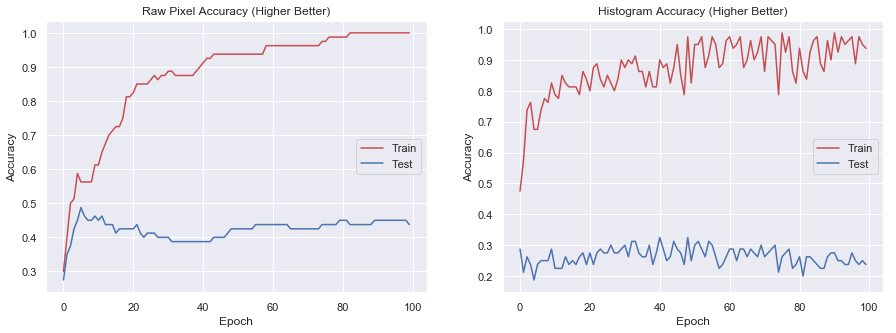

In [14]:
predict_epoch_train1 = onevsall_predict(x1_train, learnt_W_history_list)
acc_list_train1 = onevsall_accuracy(y1_train, predict_epoch_train1)

predict_epoch_train2 = onevsall_predict(x2_train, learnt_theta_history_list)
acc_list_train2 = onevsall_accuracy(y1_train, predict_epoch_train2)

predict_epoch_test1 = onevsall_predict(x1_test, learnt_W_history_list)
acc_list_test1 = onevsall_accuracy(y1_test, predict_epoch_test1)

predict_epoch_test2 = onevsall_predict(x2_test, learnt_theta_history_list)
acc_list_test2 = onevsall_accuracy(y1_test, predict_epoch_test2)



f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(acc_list_train1, color='r')
ax1.plot(acc_list_test1, color='b')
ax1.set_title('Raw Pixel Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['Train', 'Test'], loc='center right')

ax2.plot(acc_list_train2,color='r')
ax2.plot(acc_list_test2,color='b')
ax2.set_title('Histogram Accuracy (Higher Better)')
ax2.set(xlabel='Epoch', ylabel='Accuracy')
ax2.legend(['Train', 'Test'], loc='center right')    



From the plots above, we see that using the raw pixel value and histogram as features gives a test accuracy of approximately 45% and high 20% respectively which is not as good as the knn method used in question 4. 